In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk

import spacy 
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud
from collections import Counter
from nltk import word_tokenize, FreqDist
import re
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import GRU, Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from time import time
import glob


import xgboost as xgb

from imblearn.over_sampling import SMOTE, ADASYN

Using TensorFlow backend.
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Helper Functions

In [3]:
#Function to put the training and testing accuracy of each model in a list of models
def model_results_dataframe(model_list, model_names, features_train, target_train, features_test, target_test):
    #Place to start 
    result_list = []
    
    for i, model in enumerate(model_list):
        #Fit the model to the data and make predictions
        model.fit(features_train, target_train)
        training_preds = model.predict(features_train)
        testing_preds = model.predict(features_test)
        
        #Accuracy scores for each model
        train_accuracy = accuracy_score(target_train, training_preds)
        test_accuracy = accuracy_score(target_test, testing_preds)
        
        #Put them in results
        result_list.append([model_names[i],train_accuracy, test_accuracy])
    
    column_names = ['Model Name', 'Training Accuracy', 'Testing Accuracy']
    results_df = pd.DataFrame(result_list, columns=column_names)
    results_df = results_df.sort_values(by=['Testing Accuracy'], ascending=False)
    return results_df

In [4]:
#Plots a confusion matrix of a given model

def plot_confusion_matrix(y_test, model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia, origin='lower')
    classNames = ['Non-Hit','Hit']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [5]:
# Shows confusion matrix and classification report for a model after it has been fitted
def results_summary(mymodel, X_train, y_train, X_test, y_test):
    mymodel.fit(X_train, y_train)
    model_preds = mymodel.predict(X_test)
    
    model_accuracy = metrics.accuracy_score(y_test, model_preds)
    
    print("\n\nAccuracy Score: {}".format(model_accuracy))
    print("\n\nConfusion Matrix:")
    plot_confusion_matrix(y_test, model_preds)
    print("\n\nClassification Report:")
    print(metrics.classification_report(y_test, model_preds))

In [6]:
# Shows roc_curve for a model after it has been fitted.
def roc_curves(unfitted_model, X_train, y_train, X_test, y_test):
    unfitted_model.fit(X_train, y_train)
    model_preds = unfitted_model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(model_preds,y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
#Visualizes feature importance on a horizontal bar chart for a given model
def feature_importance_visualization(model, X_train, y_train, mytitle):
    model.fit(X_train, y_train)
    
    feature_importances = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
    feature_importances = feature_importances[:10]
    feature_importances = feature_importances.sort_values(ascending=True)

    plt.figure(figsize=(6,6))

    feature_importances.plot.barh(width=0.5)

    plt.title(mytitle)
    plt.show()

# Combining the Dataframes and Preprocessing

In [8]:
# Reading in both dataframes

steam_data = pd.read_csv('preprocessed_steam_data.csv')

In [9]:
steam_data.columns

Index(['Unnamed: 0', 'Name', 'ReleaseDate', 'ReleaseYear', 'Metacritic',
       'RecommendationCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
       'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree',
       'PurchaseAvail', 'SubscriptionAvail', 'PlatformWindows',
       'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
       'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
       'MacReqsHaveRec', 'CategorySinglePlayer', 'CategoryMultiplayer',
       'CategoryCoop', 'CategoryMMO', 'CategoryInAppPurchase',
       'CategoryIncludeSrcSDK', 'CategoryIncludeLevelEditor',
       'CategoryVRSupport', 'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
       'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
       'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
       'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer',
       'PriceCurrency', 'PriceFinal', 'AboutText', 'Reviews',
       'Revenue_Estima

In [10]:
# Dropping overlapping columns before the merge. The vgchartz data is more reliable for metacritic and release year information.
columns_to_drop = ['ReleaseYear', 'Metacritic']
columns_to_keep = ['Name', 'ReleaseDate', 'Metacritic', 'RecommendationCount', 'SteamSpyOwners', 'SteamSpyPlayersEstimate', 'PriceFinal',
                  'AboutText', 'Reviews']



In [11]:
steam_data_merge = steam_data[columns_to_keep]

In [12]:
steam_data_merge.head()

,Name,ReleaseDate,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyPlayersEstimate,PriceFinal,AboutText,Reviews
0,Counter-Strike,Nov 1 2000,88,68991,13033334,9140731,9.99,Play the worlds number 1 online action game. E...,
1,Team Fortress Classic,Apr 1 1999,0,2439,5399140,753627,4.99,One of the most popular online action games of...,
2,Day of Defeat,May 1 2003,79,2319,7621102,1709740,4.99,Enlist in an intense brand of Axis vs. Allied ...,
3,Deathmatch Classic,Jun 1 2001,0,888,7498965,789676,4.99,Enjoy fast-paced multiplayer gaming with Death...,
4,Half-Life: Opposing Force,Nov 1 1999,0,2934,5399499,705741,4.99,Return to the Black Mesa Research Facility as ...,


In [13]:
vgchartz_data = pd.read_csv('Preprocessed_data.csv')

In [14]:
vgchartz_data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Hit_or_not,BINARY_Hits
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,Hit,1.0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,Hit,1.0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,Hit,1.0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,Hit,1.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,Hit,1.0


In [15]:
# Need to make sure I merge on the PC games and not console games for games that were released on both
vgchartz_data['merge_name'] = vgchartz_data['Name']+"_"+vgchartz_data['Platform']

In [16]:
steam_data_merge['merge_name'] = steam_data_merge['Name']+"_PC"

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
steam_data_merge['merge_name'].head()

0               Counter-Strike_PC
1        Team Fortress Classic_PC
2                Day of Defeat_PC
3           Deathmatch Classic_PC
4    Half-Life: Opposing Force_PC
Name: merge_name, dtype: object

In [18]:
pc_games_df = vgchartz_data.merge(steam_data_merge, how='left', on='merge_name')

In [19]:
pc_games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17683 entries, 0 to 17682
Data columns (total 28 columns):
Name_x                     17683 non-null object
Platform                   17683 non-null object
Year_of_Release            17683 non-null float64
Genre                      17683 non-null object
Publisher                  17683 non-null object
NA_Sales                   17683 non-null float64
EU_Sales                   17683 non-null float64
JP_Sales                   17683 non-null float64
Other_Sales                17683 non-null float64
Global_Sales               17683 non-null float64
Critic_Score               8163 non-null float64
Critic_Count               7982 non-null float64
User_Score                 7491 non-null float64
User_Count                 7462 non-null float64
Developer                  11142 non-null object
Rating                     10562 non-null object
Hit_or_not                 17683 non-null object
BINARY_Hits                17683 non-null float64
me

In [20]:
pc_games_df.drop(pc_games_df.loc[pc_games_df['RecommendationCount'].isnull()].index, inplace=True)

In [21]:
pc_games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 283 to 17493
Data columns (total 28 columns):
Name_x                     260 non-null object
Platform                   260 non-null object
Year_of_Release            260 non-null float64
Genre                      260 non-null object
Publisher                  260 non-null object
NA_Sales                   260 non-null float64
EU_Sales                   260 non-null float64
JP_Sales                   260 non-null float64
Other_Sales                260 non-null float64
Global_Sales               260 non-null float64
Critic_Score               220 non-null float64
Critic_Count               220 non-null float64
User_Score                 234 non-null float64
User_Count                 234 non-null float64
Developer                  246 non-null object
Rating                     217 non-null object
Hit_or_not                 260 non-null object
BINARY_Hits                260 non-null float64
merge_name                 260 non

In [22]:
pc_games_df['Critic_Score'].isnull().index

Int64Index([  283,   312,   651,   657,   684,  1515,  1709,  1710,  1990,
             2076,
            ...
            16151, 16153, 16241, 16250, 16263, 16345, 16371, 16386, 16436,
            17493],
           dtype='int64', length=260)

In [23]:
pc_games_df.loc[pc_games_df['Critic_Score'].isnull(), 'Critic_Score'] = pc_games_df['Metacritic']

In [24]:
pc_games_df.loc[pc_games_df['Critic_Score'] == 0, 'Critic_Score'] = pc_games_df['Metacritic']

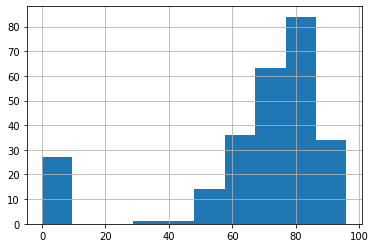

In [25]:
pc_games_df['Critic_Score'].hist()

## Here, I establish a "Steam Hit" as any game which has sold over 100,000 copies on steam. This is significantly scaled down from the 1,000,000 copy hit threshold for vgchartz. I'm mainly doing this so I have more training data for hits when I attempt modeling.

In [26]:
# Establishing steam-hit column
pc_games_df.loc[pc_games_df['Global_Sales'] >= 0.1, 'Steam_Hit'] = 1
pc_games_df.loc[pc_games_df['Global_Sales'] < 0.1, 'Steam_Hit'] = 0



In [27]:
pc_games_df['BINARY_Hits'].value_counts()

0.0    247
1.0     13
Name: BINARY_Hits, dtype: int64

In [28]:
pc_games_df['Steam_Hit'].value_counts()

0.0    174
1.0     86
Name: Steam_Hit, dtype: int64

Unfortunately I'm still missing some critic scores, but only around 30. This will have to do for now. 

In [29]:
numeric_columns = ['Name_x', 'Year_of_Release', 'Steam_Hit', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales','BINARY_Hits', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count',
       'Metacritic', 'RecommendationCount', 'SteamSpyOwners', 'SteamSpyPlayersEstimate', 'PriceFinal']

In [30]:
pc_games_df.columns

Index(['Name_x', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
       'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
       'Rating', 'Hit_or_not', 'BINARY_Hits', 'merge_name', 'Name_y',
       'ReleaseDate', 'Metacritic', 'RecommendationCount', 'SteamSpyOwners',
       'SteamSpyPlayersEstimate', 'PriceFinal', 'AboutText', 'Reviews',
       'Steam_Hit'],
      dtype='object')

In [31]:
# Quickly making a cleaned about text and review text column
#Defining stop words to remove
from nltk.corpus import stopwords
stop = stopwords.words('english')



In [32]:
# Adding a few common words that are included in the about text that don't add much detail 
stop.extend(['player', 'game', 'play', 'new', 'players', 'world'])

In [33]:
# Building a clean_text function that will lowercase, remove punctuation, and return the cleaned text
def clean_text(text):
    #Replaces all punctuation with spaces and lowercases all words
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    #Removes stopwords
    return ' '.join([word for word in text.split() if word not in (stop)])

In [34]:
pc_games_df['cleaned_about_text'] = list(map(lambda t: clean_text(t), pc_games_df['AboutText']))
pc_games_df['cleaned_review_text'] = list(map(lambda t: clean_text(t), pc_games_df['Reviews']))

# Exploring the Combined Data

**So, how many of these steam games were "hits" according to the VGChartz analysis definition of over 1 million units sold?**

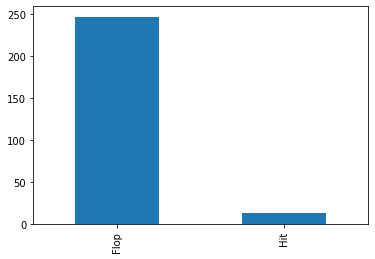

In [35]:
pc_games_df['Hit_or_not'].value_counts().plot(kind='bar')
plt.show()


In [36]:
pc_games_df.sort_values(by='Global_Sales', ascending=False)

,Name_x,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyPlayersEstimate,PriceFinal,AboutText,Reviews,Steam_Hit,cleaned_about_text,cleaned_review_text
283,Half-Life,PC,1997.0,Shooter,Vivendi Games,4.03,0.00,0.09,0.00,4.12,...,96.0,12486.0,5927504.0,2268772.0,9.99,Named Game of the Year by over 50 publications...,,1.0,named year 50 publications valves debut title ...,
312,The Elder Scrolls V: Skyrim,PC,2011.0,Role-Playing,Bethesda Softworks,1.16,2.12,0.00,0.60,3.88,...,94.0,182587.0,11428873.0,10903558.0,19.99,EPIC FANTASY REBORNThe next chapter in the hig...,,1.0,epic fantasy rebornthe next chapter highly ant...,
651,Monopoly,PC,1994.0,Misc,Hasbro Interactive,1.49,0.81,0.00,0.10,2.39,...,0.0,280.0,41968.0,38022.0,9.99,Own it all in the classic property trading gam...,,1.0,classic property trading build fortune buy sel...,
657,Half-Life 2,PC,2004.0,Shooter,Vivendi Games,2.28,0.02,0.08,0.00,2.37,...,96.0,35792.0,9901173.0,5695963.0,9.99,1998. HALF-LIFE sends a shock through the game...,,1.0,1998 half life sends shock industry combinatio...,
684,Tomb Raider II,PC,1997.0,Action,Eidos Interactive,0.91,1.25,0.00,0.13,2.29,...,0.0,477.0,764388.0,114963.0,6.99,The second instalment in the Tomb Raider serie...,,1.0,second instalment tomb raider series invites j...,
9286,Total War: WARHAMMER,PC,2016.0,Strategy,Sega,0.00,0.12,0.00,0.01,2.09,...,86.0,18583.0,979428.0,962928.0,59.99,Total War: WARHAMMERThe Old World echoes to th...,TOTAL WAR: WARHAMMER is two great tastes that ...,1.0,total war warhammerthe old echoes clamour ceas...,total war warhammer two great tastes taste gre...
13529,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0.00,0.04,0.00,0.00,1.97,...,78.0,9324.0,684577.0,670409.0,31.99,Explore a vast galaxy full of wonder! Paradox ...,,1.0,explore vast galaxy full wonder paradox develo...,
12689,Hearts of Iron IV,PC,2016.0,Strategy,Paradox Interactive,0.00,0.05,0.00,0.00,1.35,...,83.0,4693.0,391879.0,386319.0,35.99,Victory is at your fingertips! Your ability t...,,1.0,victory fingertips ability lead nation supreme...,
1515,Fallout 4,PC,2015.0,Role-Playing,Bethesda Softworks,0.51,0.67,0.00,0.10,1.29,...,84.0,72929.0,3866060.0,3739080.0,59.99,Bethesda Game Studios the award-winning creato...,,1.0,bethesda studios award winning creators fallou...,
1710,Fallout: New Vegas,PC,2010.0,Role-Playing,Bethesda Softworks,0.59,0.45,0.00,0.14,1.17,...,84.0,41001.0,4637980.0,4076078.0,9.99,Welcome to Vegas. New Vegas.Its the kind of to...,,1.0,welcome vegas vegas kind town dig grave prior ...,


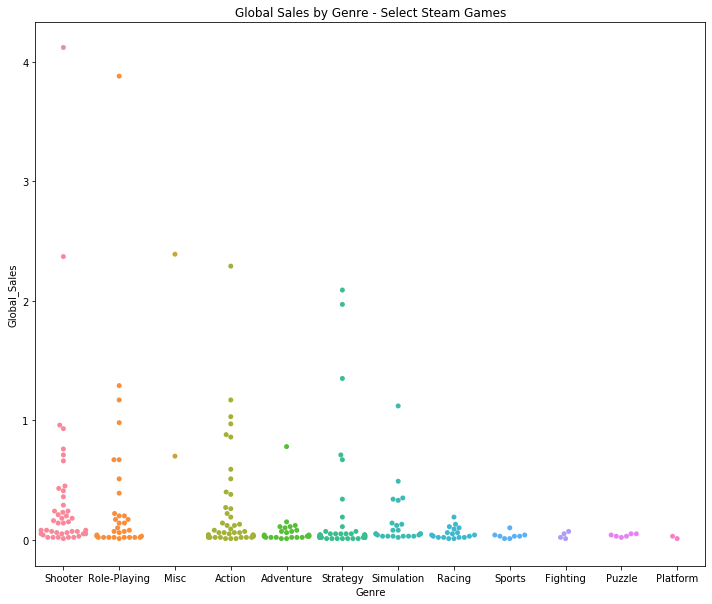

In [37]:
plt.figure(figsize=(12,10))
sns.swarmplot(x='Genre', y='Global_Sales', data=pc_games_df)
plt.title('Global Sales by Genre - Select Steam Games')
plt.show()

Clearly there are a ton of outliers in the data, especially in the shooter, roleplaying, and action categories. 


## Exploring Combined Numeric Data

In [38]:
name_and_numeric = pc_games_df[numeric_columns]

In [39]:
name_and_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 283 to 17493
Data columns (total 18 columns):
Name_x                     260 non-null object
Year_of_Release            260 non-null float64
Steam_Hit                  260 non-null float64
NA_Sales                   260 non-null float64
EU_Sales                   260 non-null float64
JP_Sales                   260 non-null float64
Other_Sales                260 non-null float64
Global_Sales               260 non-null float64
BINARY_Hits                260 non-null float64
Critic_Score               260 non-null float64
Critic_Count               220 non-null float64
User_Score                 234 non-null float64
User_Count                 234 non-null float64
Metacritic                 260 non-null float64
RecommendationCount        260 non-null float64
SteamSpyOwners             260 non-null float64
SteamSpyPlayersEstimate    260 non-null float64
PriceFinal                 260 non-null float64
dtypes: float64(17), object(

In [40]:
name_and_numeric.drop(name_and_numeric.loc[name_and_numeric['Critic_Score']==0].index, inplace=True)

C:\Users\Alex\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [41]:
name_and_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 283 to 16436
Data columns (total 18 columns):
Name_x                     233 non-null object
Year_of_Release            233 non-null float64
Steam_Hit                  233 non-null float64
NA_Sales                   233 non-null float64
EU_Sales                   233 non-null float64
JP_Sales                   233 non-null float64
Other_Sales                233 non-null float64
Global_Sales               233 non-null float64
BINARY_Hits                233 non-null float64
Critic_Score               233 non-null float64
Critic_Count               220 non-null float64
User_Score                 221 non-null float64
User_Count                 221 non-null float64
Metacritic                 233 non-null float64
RecommendationCount        233 non-null float64
SteamSpyOwners             233 non-null float64
SteamSpyPlayersEstimate    233 non-null float64
PriceFinal                 233 non-null float64
dtypes: float64(17), object(

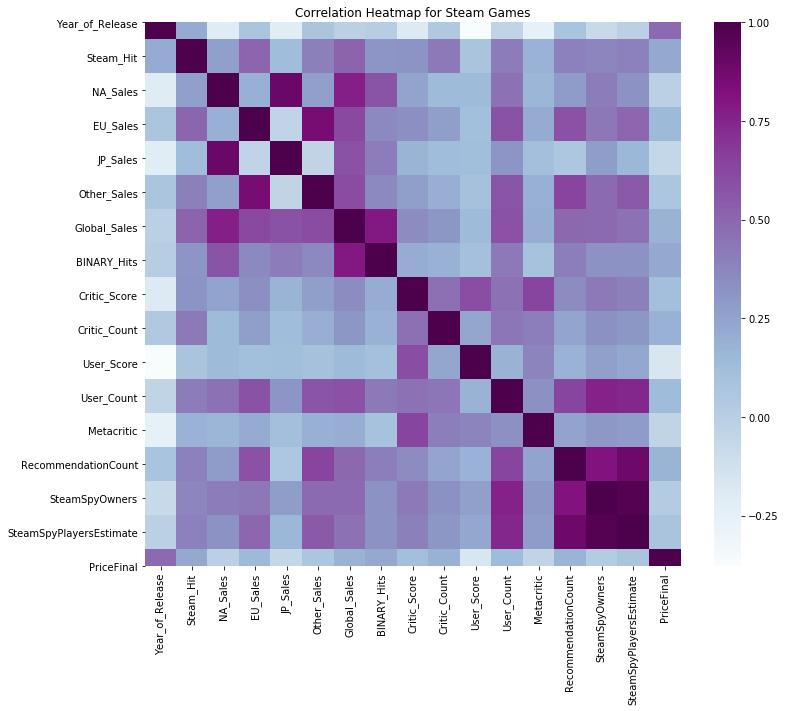

In [42]:
# Calculate correlations
corr = name_and_numeric.corr()
 
# Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="BuPu")
plt.title('Correlation Heatmap for Steam Games')
plt.show()

## Correlation Matrix takeaways

- Unsurprisingly, the regional sales categories are all fairly highly correlated, with the exception of JP and EU Sales
- BINARY Hits appears to be correlated with the following categories
    - Global_Sales (obviously, since this is how a "hit" is calculated)
    - NA_Sales, EU_Sales, JP_Sales
    - User_Count
    - Recommendation_count
    - SteamSpyOwners
    - SteamSpyPlayersEstimate
    - Critic Score (weaker correlation)


In [43]:
# Checking out how many hits we have left in here
pc_games_df['BINARY_Hits'].value_counts()

0.0    247
1.0     13
Name: BINARY_Hits, dtype: int64

In [44]:
# Looking at the distribution of global sales for the games left
len(pc_games_df.loc[pc_games_df['Global_Sales'] > 0.1])

82

## Exploring About Text by Genre

In [45]:
pc_games_df['Genre'].value_counts()

Strategy        49
Action          48
Shooter         43
Role-Playing    32
Adventure       25
Simulation      23
Racing          18
Sports           8
Puzzle           6
Fighting         4
Misc             2
Platform         2
Name: Genre, dtype: int64

In [46]:
genre_columns = ['Strategy', 'Action', 'Shooter', 'Role-Playing', 'Adventure', 'Simulation', 'Racing', 'Sports']

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove

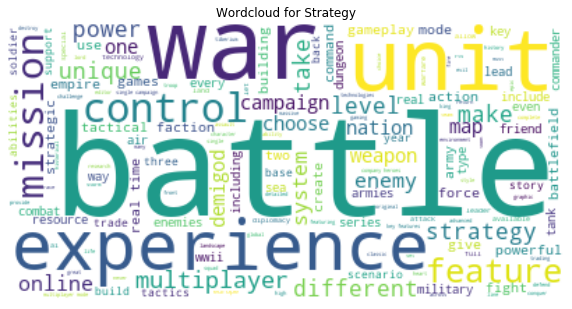

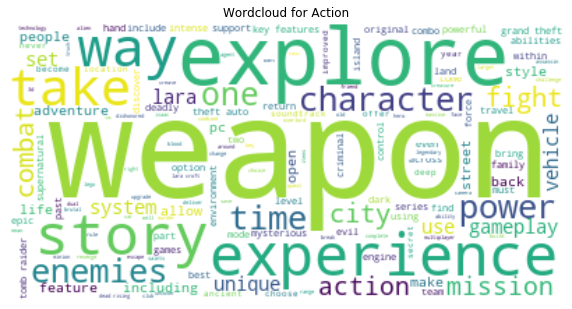

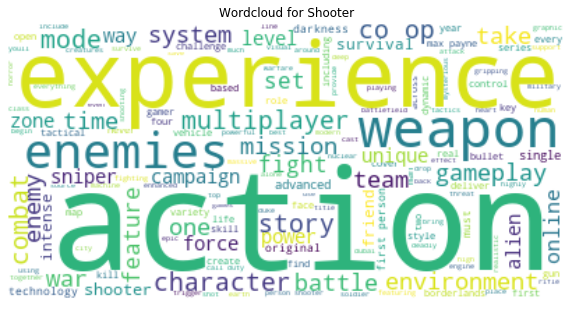

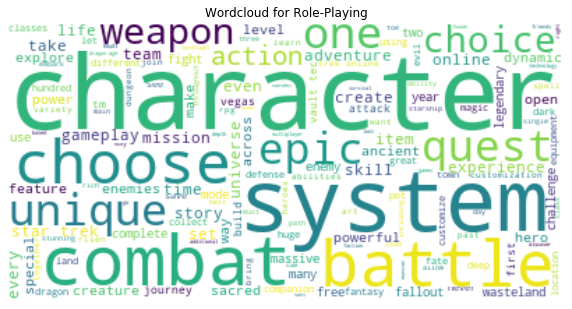

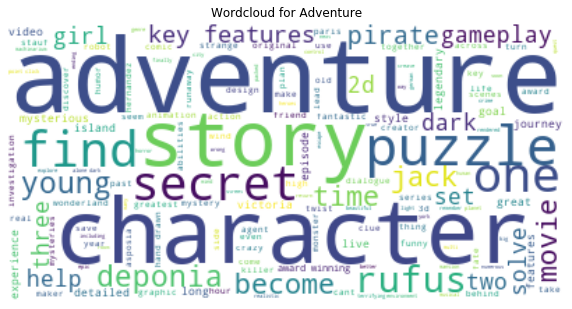

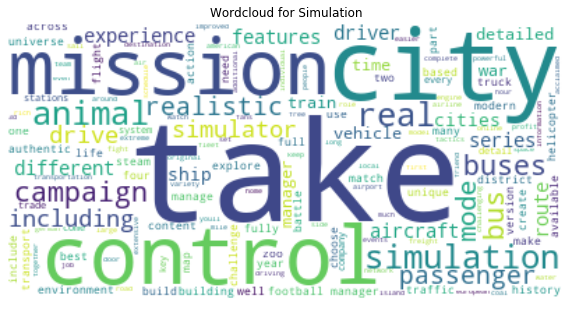

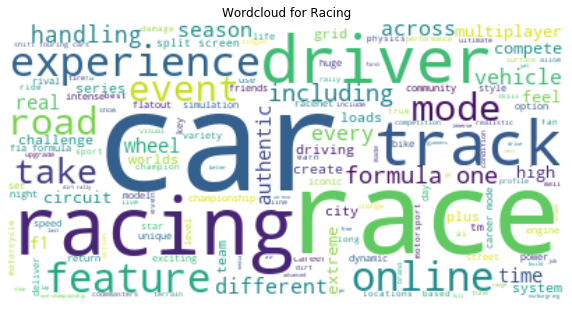

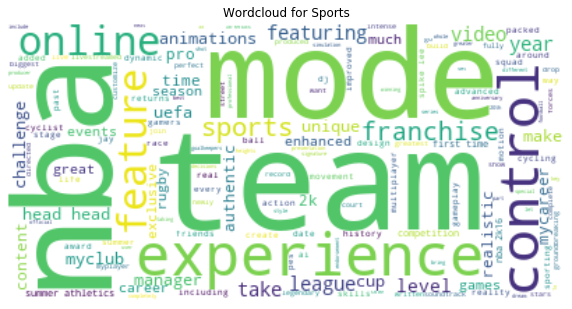

In [47]:
for genre in genre_columns:
    #Wordcloud for just HIT games
    text_genre = " ".join(text for text in pc_games_df.loc[pc_games_df['Genre'] == genre, 'cleaned_about_text'])
    wordcloud_genre = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_genre)
    #Visualization of flop wordcloud
    fig = plt.figure(figsize = (10,8))
    plt.imshow(wordcloud_genre, interpolation='bilinear')
    plt.title('Wordcloud for {}'.format(genre))
    plt.axis('off')
    fig.show()

Awesome! In this visual it's easier to see the different word tendencies in descriptions for different genres.

Slightly more balanced than before, with 86 positive cases instead of just 13.

In [48]:
pc_games_df['Critic_Score'].mean()

67.69615384615385

In [49]:
# # Filling in 0 critic scores with the mean for the group. Not ideal but butter than eliminating critc score
# pc_games_df.loc[pc_games_df['Critic_Score'] == 0, 'Critic_Score'] = pc_games_df['Critic_Score'].mean()


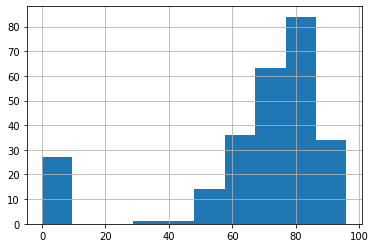

In [50]:
pc_games_df['Critic_Score'].hist()

# Attempting Machine Learning Models for Combined Data

Unfortunately, after combining the two dataframes I only have around 250 games to work with for machine learning.

This is probably too few to get meaningful results from any sort of model, as most will be overfitted due to lack of sufficient training examples. 

- Model 1: Using only numeric data
- Model 2: Adding in categorical data

## Model 1: Machine Learning Using Numeric Data

In [51]:
name_and_numeric.columns

Index(['Name_x', 'Year_of_Release', 'Steam_Hit', 'NA_Sales', 'EU_Sales',
       'JP_Sales', 'Other_Sales', 'Global_Sales', 'BINARY_Hits',
       'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count',
       'Metacritic', 'RecommendationCount', 'SteamSpyOwners',
       'SteamSpyPlayersEstimate', 'PriceFinal'],
      dtype='object')

In [52]:
numeric_model_df = name_and_numeric.drop(['Name_x', 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)

In [53]:
# Dropping any existing null values
numeric_model_df.dropna(inplace=True)

In [54]:
numeric_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 283 to 16436
Data columns (total 12 columns):
Year_of_Release            219 non-null float64
Steam_Hit                  219 non-null float64
BINARY_Hits                219 non-null float64
Critic_Score               219 non-null float64
Critic_Count               219 non-null float64
User_Score                 219 non-null float64
User_Count                 219 non-null float64
Metacritic                 219 non-null float64
RecommendationCount        219 non-null float64
SteamSpyOwners             219 non-null float64
SteamSpyPlayersEstimate    219 non-null float64
PriceFinal                 219 non-null float64
dtypes: float64(12)
memory usage: 22.2 KB


In [55]:
features = numeric_model_df.drop(['Steam_Hit'], axis=1)
target = numeric_model_df['Steam_Hit']

In [56]:
#Scaling all X data here
scale = StandardScaler()
scaled_X = features.copy()
scaled_X = pd.DataFrame(scale.fit_transform(scaled_X), columns=features.columns)

In [57]:
#Without any sort of hyperparameter tuning- first attempt only
binary_svm = SVC(kernel="rbf", C=2, random_state = 11)
binary_forest = RandomForestClassifier(random_state = 11)
binary_nb = GaussianNB()
binary_knn = KNeighborsClassifier()
binary_gradient = GradientBoostingClassifier(random_state = 11)
binary_adaboost = AdaBoostClassifier(random_state = 11)
binary_bag = BaggingClassifier(random_state = 11)
binary_tree = DecisionTreeClassifier(random_state = 11)
binary_XGB = xgb.XGBClassifier(seed = 11)

In [58]:
# Putting them into a list of models that I can than iterate over using my helper functions
list_of_models = [binary_svm, binary_forest, binary_nb, binary_knn, binary_gradient, binary_adaboost, binary_bag, binary_tree, binary_XGB]
list_of_model_names = ['SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'Gradient Boost', 'ADA Boost', 'Bagging', 'Decision Tree', 'XGB']

In [59]:
# Establishing train and test
X_train, X_test, y_train, y_test = train_test_split(scaled_X, target, test_size=0.20, random_state= 10)  

In [60]:
# Rebalancing classes using SMOTE
print(y_train.value_counts()) #Previous original class distribution
X_train_resamples = pd.DataFrame(scale.fit_transform(scaled_X), columns=features.columns)

X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts())

0.0    115
1.0     60
Name: Steam_Hit, dtype: int64
0.0    115
1.0    115
dtype: int64


In [61]:
model_results = model_results_dataframe(list_of_models, list_of_model_names, X_train_resampled, y_train_resampled, X_test.values, y_test.values)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [62]:
model_results

,Model Name,Training Accuracy,Testing Accuracy
0,SVM,0.852174,0.863636
3,KNN,0.860870,0.840909
8,XGB,0.982609,0.840909
4,Gradient Boost,1.000000,0.818182
5,ADA Boost,0.947826,0.795455
7,Decision Tree,1.000000,0.795455
1,Random Forest,0.991304,0.772727
2,Naive Bayes,0.730435,0.772727
6,Bagging,0.982609,0.704545


Sort of as I expected, most of the models are far too overfitted. However: SVM, NB, and KNN show promise. I will explore these further below.

**SVM Summary**

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)




Accuracy Score: 0.8636363636363636


Confusion Matrix:


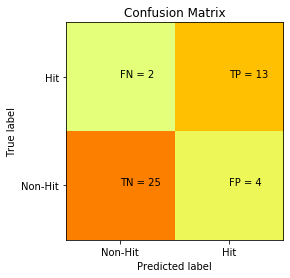



Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89        29
         1.0       0.76      0.87      0.81        15

    accuracy                           0.86        44
   macro avg       0.85      0.86      0.85        44
weighted avg       0.87      0.86      0.87        44



In [63]:
results_summary(binary_svm, X_train_resampled, y_train_resampled, X_test, y_test)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


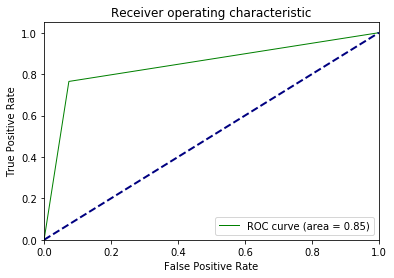

In [64]:
roc_curves(binary_svm, X_train_resampled, y_train_resampled, X_test, y_test)

**NB Summary**



Accuracy Score: 0.7727272727272727


Confusion Matrix:


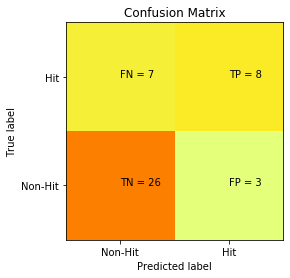



Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84        29
         1.0       0.73      0.53      0.62        15

    accuracy                           0.77        44
   macro avg       0.76      0.71      0.73        44
weighted avg       0.77      0.77      0.76        44



In [65]:
results_summary(binary_nb, X_train_resampled, y_train_resampled, X_test, y_test)

**KNN Summary**



Accuracy Score: 0.8409090909090909


Confusion Matrix:


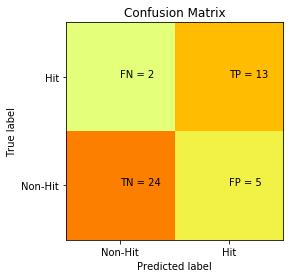



Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87        29
         1.0       0.72      0.87      0.79        15

    accuracy                           0.84        44
   macro avg       0.82      0.85      0.83        44
weighted avg       0.85      0.84      0.84        44



In [66]:
results_summary(binary_knn, X_train_resampled, y_train_resampled, X_test, y_test)

**Random Forest Feature Importance**

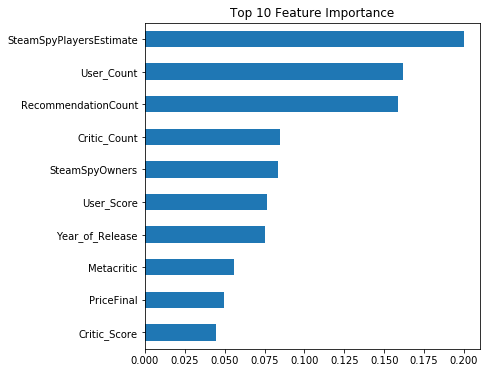

In [67]:
feature_importance_visualization(binary_forest, X_train, y_train, 'Top 10 Feature Importance')

## Numeric Modeling Conclusions

- SteamSpyPlayersEstimate and User_Count are the two more important features for just numeric models.
- Much to my surprise, there is a very low importance on critic score, which was a critical component of the models in the vgchartz dataset. Perhaps this is a result of the lack of data.

## Model 2: Categorical and Numerical Features Combined Model

**Adding Categorical Variables to the Model**
- Publisher
- Genre
- Rating

Before doing this, I wanted to reduce dimensionality similar to how I reduced dimensionality 

In [68]:
pc_games_df['Publisher'].value_counts().sort_values(ascending=False)

Take-Two Interactive                      24
Paradox Interactive                       16
Eidos Interactive                         14
Electronic Arts                           14
THQ                                       13
Focus Home Interactive                    10
Unknown                                   10
Codemasters                               10
Bethesda Softworks                         9
Deep Silver                                8
Square Enix                                7
Kalypso Media                              7
Capcom                                     7
Atari                                      6
Sega                                       5
Ubisoft                                    5
Warner Bros. Interactive Entertainment     5
DTP Entertainment                          5
Vivendi Games                              4
Rondomedia                                 4
Daedalic Entertainment                     3
Konami Digital Entertainment               3
Iceberg In

In [69]:
# Forming a publisher count df
publisher_count_df = pc_games_df.groupby('Publisher', axis=0).count().reset_index()[['Publisher', 'Year_of_Release']]

In [70]:
publisher_count_df.head()

,Publisher,Year_of_Release
0,1C Company,2
1,2D Boy,1
2,Activision,3
3,Aerosoft,1
4,Alawar Entertainment,1


In [71]:
one_game_publishers = list(publisher_count_df.loc[(publisher_count_df['Year_of_Release'] == 1)]['Publisher'])

In [72]:
one_game_publishers

['2D Boy',
 'Aerosoft',
 'Alawar Entertainment',
 'Alternative Software',
 'Avanquest',
 'CCP',
 'CDV Software Entertainment',
 'Disney Interactive Studios',
 'Encore',
 'Funcom',
 'Gathering of Developers',
 'HMH Interactive',
 'Hasbro Interactive',
 'Headup Games',
 'Insomniac Games',
 'Koch Media',
 'Mastiff',
 'Milestone S.r.l',
 'Mumbo Jumbo',
 'Namco Bandai Games',
 'Number None',
 'PQube',
 'PopCap Games',
 'Reef Entertainment',
 'SCS Software',
 'Slightly Mad Studios',
 'Square Enix ',
 'Strategy First',
 'Sunflowers',
 'Team17 Software',
 'Touchstone',
 'Trion Worlds',
 'Virgin Interactive',
 'inXile Entertainment']

In [73]:
for publisher in one_game_publishers:
    pc_games_df.loc[pc_games_df['Publisher'] == publisher, 'Publisher'] = 'One Game Publisher'

In [74]:
between_one_and_six_publishers = list(publisher_count_df.loc[(publisher_count_df['Year_of_Release'] <6) & 
                                                     (publisher_count_df['Year_of_Release'] >1)]['Publisher'])

In [75]:
between_one_and_six_publishers

['1C Company',
 'Activision',
 'Ascaron Entertainment GmbH',
 'Astragon',
 'City Interactive',
 'Crimson Cow',
 'DTP Entertainment',
 'Daedalic',
 'Daedalic Entertainment',
 'Empire Interactive',
 'Iceberg Interactive',
 'JoWood Productions',
 'Konami Digital Entertainment',
 'MC2 Entertainment',
 'Mastertronic',
 'Microids',
 'Microsoft Game Studios',
 'Nordic Games',
 'Rondomedia',
 'Sega',
 'Ubisoft',
 'Valve Software',
 'Vivendi Games',
 'Warner Bros. Interactive Entertainment',
 'bitComposer Games']

In [76]:
for publisher in between_one_and_six_publishers:
    pc_games_df.loc[pc_games_df['Publisher'] == publisher, 'Publisher'] = 'Less than Six Game Publisher'

In [77]:
pc_games_df['Publisher'].value_counts().sort_values(ascending=False)

Less than Six Game Publisher    71
One Game Publisher              34
Take-Two Interactive            24
Paradox Interactive             16
Electronic Arts                 14
Eidos Interactive               14
THQ                             13
Codemasters                     10
Unknown                         10
Focus Home Interactive          10
Bethesda Softworks               9
Deep Silver                      8
Capcom                           7
Square Enix                      7
Kalypso Media                    7
Atari                            6
Name: Publisher, dtype: int64

In [78]:
pc_games_df.columns

Index(['Name_x', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
       'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
       'Rating', 'Hit_or_not', 'BINARY_Hits', 'merge_name', 'Name_y',
       'ReleaseDate', 'Metacritic', 'RecommendationCount', 'SteamSpyOwners',
       'SteamSpyPlayersEstimate', 'PriceFinal', 'AboutText', 'Reviews',
       'Steam_Hit', 'cleaned_about_text', 'cleaned_review_text'],
      dtype='object')

In [79]:
columns_to_drop = ['Name_x', 'Platform', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Developer', 'Hit_or_not', 'BINARY_Hits', 'merge_name', 'Name_y',
       'ReleaseDate', 'Metacritic', 'AboutText', 'Reviews',
       'cleaned_about_text', 'cleaned_review_text']
combined_modeling_df = pc_games_df.drop(columns_to_drop, axis=1)

In [80]:
combined_modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 283 to 17493
Data columns (total 13 columns):
Year_of_Release            260 non-null float64
Genre                      260 non-null object
Publisher                  260 non-null object
Critic_Score               260 non-null float64
Critic_Count               220 non-null float64
User_Score                 234 non-null float64
User_Count                 234 non-null float64
Rating                     217 non-null object
RecommendationCount        260 non-null float64
SteamSpyOwners             260 non-null float64
SteamSpyPlayersEstimate    260 non-null float64
PriceFinal                 260 non-null float64
Steam_Hit                  260 non-null float64
dtypes: float64(10), object(3)
memory usage: 38.4+ KB


In [81]:
# Dropping null values
combined_modeling_df.dropna(inplace=True)

In [82]:
len(combined_modeling_df)

197

In [83]:
# Getting cat variables
categorical = combined_modeling_df.loc[:, combined_modeling_df.dtypes == np.object]

#converting data types to "category", helpful for Keras
for col in categorical.columns: 
    categorical[col] = categorical[col].astype('category')

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 283 to 16371
Data columns (total 3 columns):
Genre        197 non-null category
Publisher    197 non-null category
Rating       197 non-null category
dtypes: category(3)
memory usage: 3.5 KB


In [85]:
#Pulling dummies for categorical variables
dummy_cat_df = pd.get_dummies(categorical)

In [86]:
dummy_cat_df.head()

,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,...,Publisher_Paradox Interactive,Publisher_Square Enix,Publisher_THQ,Publisher_Take-Two Interactive,Publisher_Unknown,Rating_E,Rating_E10+,Rating_M,Rating_RP,Rating_T
283,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
312,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
657,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1515,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1709,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [87]:
dummy_cat_df.columns[10]

'Genre_Strategy'

In [88]:
# Scaling Numeric Features
number_model_columns = ['Year_of_Release', 'Critic_Score', 'Critic_Count' ,'User_Count', 'User_Score', 'RecommendationCount', 
                       'SteamSpyOwners', 'SteamSpyPlayersEstimate', 'PriceFinal']
scale = StandardScaler()
scaled_X = combined_modeling_df[number_model_columns]

In [89]:
scaled_X['Year_of_Release'] = scale.fit_transform(scaled_X.Year_of_Release.values.reshape(-1,1))
scaled_X['Critic_Score'] = scale.fit_transform(scaled_X.Critic_Score.values.reshape(-1,1))
scaled_X['Critic_Count'] = scale.fit_transform(scaled_X.Critic_Count.values.reshape(-1,1))
scaled_X['User_Score'] = scale.fit_transform(scaled_X.User_Score.values.reshape(-1,1))
scaled_X['User_Count'] = scale.fit_transform(scaled_X.User_Count.values.reshape(-1,1))
scaled_X['RecommendationCount'] = scale.fit_transform(scaled_X.RecommendationCount.values.reshape(-1,1))
scaled_X['SteamSpyOwners'] = scale.fit_transform(scaled_X.SteamSpyOwners.values.reshape(-1,1))
scaled_X['SteamSpyPlayersEstimate'] = scale.fit_transform(scaled_X.RecommendationCount.values.reshape(-1,1))
scaled_X['PriceFinal'] = scale.fit_transform(scaled_X.SteamSpyOwners.values.reshape(-1,1))

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [90]:
scaled_X.head()

,Year_of_Release,Critic_Score,Critic_Count,User_Count,User_Score,RecommendationCount,SteamSpyOwners,SteamSpyPlayersEstimate,PriceFinal
283,-2.957810,1.812406,-0.323875,1.443100,1.271933,0.099275,2.002668,0.099275,2.002668
312,0.311785,1.631119,0.162709,5.172990,0.609047,7.097837,4.413888,7.097837,4.413888
657,-1.323012,1.812406,3.143040,4.915582,1.271933,1.058167,3.744306,1.058167,3.744306
1515,1.245955,0.724686,0.527648,4.188153,-1.180745,2.586116,1.099149,2.586116,1.099149
1709,1.245955,1.812406,1.683286,1.818486,0.476470,5.215889,1.984510,5.215889,1.984510


In [91]:
## PROBLEM IS HERE
final_modeling_features = pd.concat([scaled_X, dummy_cat_df], axis=1, join_axes=[scaled_X.index])

In [92]:
len(final_modeling_features)

197

In [93]:
# Setting target and features before modeling
target = combined_modeling_df['Steam_Hit']
features = final_modeling_features

In [94]:
#Without any sort of hyperparameter tuning- first attempt only
binary_svm = SVC(kernel="rbf", C=2, random_state = 11)
binary_forest = RandomForestClassifier(random_state = 11)
binary_nb = GaussianNB()
binary_knn = KNeighborsClassifier()
binary_gradient = GradientBoostingClassifier(random_state = 11)
binary_adaboost = AdaBoostClassifier(random_state = 11)
binary_bag = BaggingClassifier(random_state = 11)
binary_tree = DecisionTreeClassifier(random_state = 11)
binary_XGB = xgb.XGBClassifier(seed = 11)

In [95]:
# Putting them into a list of models that I can than iterate over using my helper functions
list_of_models = [binary_svm, binary_forest, binary_nb, binary_knn, binary_gradient, binary_adaboost, binary_bag, binary_tree, binary_XGB]
list_of_model_names = ['SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'Gradient Boost', 'ADA Boost', 'Bagging', 'Decision Tree', 'XGB']

In [96]:
# Establishing train and test
X_train, X_test, y_train, y_test = train_test_split(final_modeling_features, target, test_size=0.20, random_state= 10)  

In [97]:
# Rebalancing classes using SMOTE
print(y_train.value_counts()) #Previous original class distribution

X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts())

0.0    105
1.0     52
Name: Steam_Hit, dtype: int64
1.0    105
0.0    105
dtype: int64


In [98]:
model_results = model_results_dataframe(list_of_models, list_of_model_names, X_train_resampled, y_train_resampled, X_test.values, y_test.values)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [99]:
model_results

,Model Name,Training Accuracy,Testing Accuracy
6,Bagging,0.995238,0.775
7,Decision Tree,1.000000,0.775
0,SVM,0.885714,0.750
1,Random Forest,1.000000,0.750
8,XGB,0.985714,0.750
3,KNN,0.880952,0.725
4,Gradient Boost,1.000000,0.725
5,ADA Boost,0.976190,0.625
2,Naive Bayes,0.647619,0.475


## Unsuprisingly, adding these categorical dimensions on a tiny dataframe created overfitting. I will explore the NB and KNN model to see how they performed. I will also investigate Gradient Boost because it has performed so well for other models in this project.

**KNN**



Accuracy Score: 0.725


Confusion Matrix:


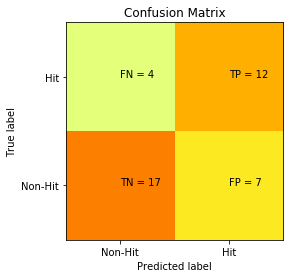



Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76        24
         1.0       0.63      0.75      0.69        16

    accuracy                           0.73        40
   macro avg       0.72      0.73      0.72        40
weighted avg       0.74      0.72      0.73        40



In [100]:
results_summary(binary_knn, X_train_resampled, y_train_resampled, X_test, y_test)

**Naive Bayes**



Accuracy Score: 0.475


Confusion Matrix:


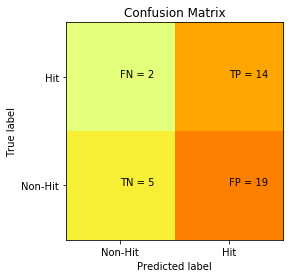



Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.21      0.32        24
         1.0       0.42      0.88      0.57        16

    accuracy                           0.48        40
   macro avg       0.57      0.54      0.45        40
weighted avg       0.60      0.47      0.42        40



In [101]:
results_summary(binary_nb, X_train_resampled, y_train_resampled, X_test, y_test)

**Random Forest Feature Importance**

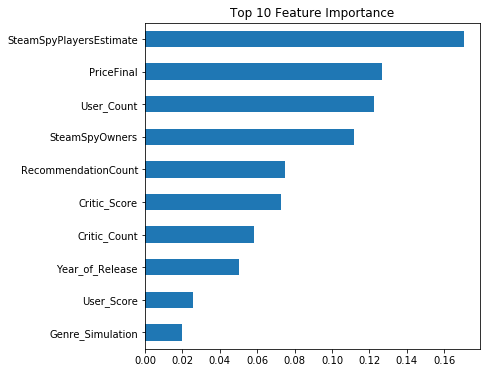

In [102]:
feature_importance_visualization(binary_forest, X_train, y_train, 'Top 10 Feature Importance')

**XGB**



Accuracy Score: 0.725


Confusion Matrix:


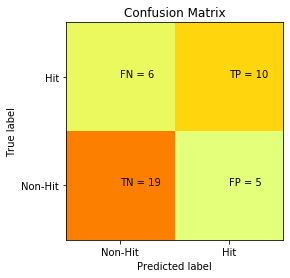



Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78        24
         1.0       0.67      0.62      0.65        16

    accuracy                           0.73        40
   macro avg       0.71      0.71      0.71        40
weighted avg       0.72      0.72      0.72        40



In [103]:
results_summary(binary_gradient, X_train_resampled, y_train_resampled, X_test, y_test)

# Combined Modeling Conclusions

- Very difficult to predict based on so few training examples.
- Still, around 65% accuracy fore hits, with roughly balanced recall and precision.
    - These are good results, I'm just not sure this modeling would be able to take in new data and succeed because it was trained on so few examples.
   

# Future Model Improvements

**Lack of Data**

As mentioned above, the overlapping data between vgchartz and the steam dataset was less than 300 words. For machine learning algorithms like the ones implemented in this notebook, more data is always better. Part of the reason for this lack of data is due to the growing popularity of other PC-based game clients. More and more, hit titles are making gaming "launchers" like steam compete for their business. Besides Steam, several other launchers have emerged as serious competitors.

- Uplay
- Battle.net Launcher
- Origin
- Epic Games Launcher
- GOG
- Bethesda Launcher
- Microsoft Store

Due to this competition, the number of hit and popular PC games that are released on steam is continuously dwindling. Especially large releases that are likely to be documented by vgchartz. 

Ideally, public data and statistics would be available for all of these launchers. This would increase the overlap between the PC gaming dataset and the vgchartz dataset and drastically improve modeling as model training sizes improve.

**Improved Handling of Categorical Variables**

Given the lack of extensive numerical information, the models in this notebook depended heavily on categorical variables. Several of these categorical variables had a lot of different dimensions: particularly publishers. Before any trimming, there were over 500 publishers, which I ended up condensing down into about 20 by grouping them by size. While this was an acceptable fix for the purposes of modeling, I would like to find better ways to manipulate categorical data to include it in modeling. Simple one-hot encoding sparse vectors seems like a clunky and out-dated solution. 


